In [1]:
#downloading datasets
import torchvision as thv
import numpy as np
train = thv.datasets.MNIST('../dat///////a' , download=True , train=True ) #training set
val = thv.datasets.MNIST('../data' , download=True , train=False ) #testing set
print(val.data.shape , len(train.targets) )

torch.Size([10000, 28, 28]) 60000


In [139]:
#selecting 50% of train and test sets to make new train and test data
train_indx = np.random.randint(low=0, high=60000, size=30000) #selecting 30000 training index
X_train = np.array(train.data[train_indx])
X_train = X_train.reshape(30000,-1) #flattening the image data
y_train = np.array(train.targets[train_indx])

val_indx = np.random.randint(low=0, high=10000, size=5000) #selecting 5000 test index
X_val = np.array(val.data[val_indx])
X_val = X_val.reshape(5000,-1) #flattening image data
y_val = np.array(val.targets[val_indx])

#normalizing pixel values 
X_train = X_train.astype(float) / 255
X_val = X_val.astype(float) / 255

In [140]:
class LinearLayer_t:
    def __init__(self):
        #initializing weights and biases
        self.weights = np.random.normal(0,0.01, size = (784,10))
        self.biases = np.random.normal(0,0.01, size = (1,10))
        #setting dw and db to zero
        self.grad_weights = np.array([])
        self.grad_biases = np.array([])
        
    def forward(self,x):

        self.x = x #saving input data for backward function
        linear_forward = np.dot(x,self.weights) + self.biases #linear transformation
        return linear_forward
    
    def backward(self,grad_output):
        # computing dL/dw = dz/dw*(previous layer backpropagation value)
        #dz/dw = x
        #grad output = dL/da*da/dz
        self.grad_weights = np.dot(self.x.T, grad_output)
        self.grad_biases = grad_output.mean(axis=0)*self.x.shape[0]

        #dL/dw and dL/db will be accessed from main function when computing SGD step
        return None
    
    def zero_grad(self):
        #setting all gradient values to 0
        self.grad_weights = self.grad_weights*0
        self.grad_biases = self.grad_biases*0
        return None
    

In [141]:
class Relu_t:
    def __init__(self):
        #no initialization
        pass
    
    def forward(self, input_vector):
        #applying a = max(0,z) transformation for reLU and saving a 
        #for backward function
        self.relu_forward = np.maximum(0,input_vector)
        return self.relu_forward
    
    def backward(self, grad_output):
        a = self.relu_forward  
        #grad output = dL/da
        #differentiation of reLU da/dz
        a[a>0] = 1
        a[a<0] = 0
        
        return grad_output*a #gradient value = dL/da*da/dz

In [142]:
class Softmax_Cross_Entropy_t:
    def __init__(self):
        pass
    
    #def Softmax(self,vector):
        #e = np.exp(vector)
       # return e / e.sum()
    #Cross Entropy Loss
   # def cross_entropy(self,actual,pred):
       # loss= -np.log(pred)
        #return loss
    

    def forward(self,z, yhat):
        
        self.softmax = np.exp(z) / np.exp(z).sum(axis=-1,keepdims=True) #softmax output is saved for backward function and predict function
        #taking prediction probability of only those y's that belong to corresponding targets
        y_pred_prob = z[np.arange(len(z)),yhat]
        #cross entropy loss
        entropy = - y_pred_prob + np.log(np.sum(np.exp(z),axis=-1))
        return entropy 
    
    def backward(self,yhat):

        #first creating array with zeros of the same shape as softmax output
        temp_array = np.zeros_like(self.softmax)
        #selecting only those elements in array whose index = target values 
        #and making them 1 while rest are 0
        temp_array[np.arange(len(self.softmax)),yhat] = 1
        #computing gradient at output layer dL/da
        return (- temp_array + self.softmax) / self.softmax.shape[0]
    
    def predict(self):
      self.labels= np.array([]) #creating array for predicted labels
      for i in range(len(self.softmax)):
        self.labels=np.append(self.labels,np.argmax(self.softmax[i])) #index of maximum probability will be the class label
      return self.labels


In [147]:
#training
#shuffling dataset:
indx = np.arange(len(y_train))
np.random.shuffle(indx)
X_train = X_train[indx]
y_train = y_train[indx]

#layers
l1 , l2 , l3 = LinearLayer_t() , Relu_t() , Softmax_Cross_Entropy_t()
#making gradients 0 before starting training 


#input batch size and learning rate:
n = int(input("Enter minibatch size: "))
learning_rate = float(input("Enter learning rate: "))

loss_graph=[]

#training start: 
for t in range (1000): #epoch loop
  loss_in_epoch=0
  l1.zero_grad()
  for i in range(0,30000,n): #minibatch loop
    if(i+n)>30000: #condition for out of bound index
      x = X_train[i:30000]
      y = y_train[i:30000]

    elif i+n<30000:
      x = X_train[i:i+n]
      y = y_train[i:i+n]
    
    #forward pass
    a1 = l1.forward(x)
    a2 = l2.forward(a1)
    #print(a2.shape)
    loss = l3.forward(a2,y)
    loss_in_epoch = loss_in_epoch+np.mean(loss) #total loss in every epoch

    #backward pass
    da2 = l3.backward(y)
    da1 = l2.backward(da2)
    l1.backward(da1)
    #gather backprop gradients
    grad_weights,grad_biases = l1.grad_weights, l1.grad_biases      
    #print(grad_weights.shape)
    #print(grad_biases.shape)
    
    #Updating weights and bias
    l1.weights = l1.weights - learning_rate * grad_weights
    l1.biases = l1.biases - learning_rate * grad_biases


  print("Epoch number: {}, Avg Loss: {}".format(t+1,loss_in_epoch/(int(30000/n))))
  loss_graph.append(loss_in_epoch/(int(30000/n))) #dividing loss in one epoch by the total number of steps by in one epoch



Enter minibatch size: 32
Enter learning rate: 0.1
Epoch number: 1, Avg Loss: 0.7403685491828189
Epoch number: 2, Avg Loss: 0.563176032660978
Epoch number: 3, Avg Loss: 0.5343159405487558
Epoch number: 4, Avg Loss: 0.5186204963831128
Epoch number: 5, Avg Loss: 0.5080296632183424
Epoch number: 6, Avg Loss: 0.5001896115660694
Epoch number: 7, Avg Loss: 0.4940131901058532
Epoch number: 8, Avg Loss: 0.4888894894196027
Epoch number: 9, Avg Loss: 0.484555189616066
Epoch number: 10, Avg Loss: 0.480750614241297
Epoch number: 11, Avg Loss: 0.47740674802764593
Epoch number: 12, Avg Loss: 0.4744351503044265
Epoch number: 13, Avg Loss: 0.4717785364384865
Epoch number: 14, Avg Loss: 0.46932798249268637
Epoch number: 15, Avg Loss: 0.4670506738048738
Epoch number: 16, Avg Loss: 0.46497295324143945
Epoch number: 17, Avg Loss: 0.46305163850190456
Epoch number: 18, Avg Loss: 0.46129542820172537
Epoch number: 19, Avg Loss: 0.4596146947202221
Epoch number: 20, Avg Loss: 0.45804205482126786
Epoch number: 21

Text(0.5, 1.0, 'Training Loss vs Epoch for Problem 1')

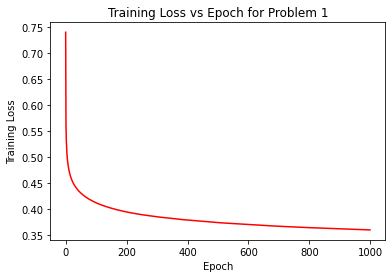

In [148]:
#plotting graph of training loss vs epoch
from matplotlib import pyplot as plt 

x = np.arange(len(loss_graph))
y = loss_graph
plt.plot(x,y,'r')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch for Problem 1")

In [149]:
#validation
def validate(val_data,val_labels):
  #forward pass only
  a1 = l1.forward(val_data)
  a2 = l2.forward(a1)
  loss= np.mean(l3.forward(a2,val_labels))
  return np.array(l3.predict()),loss #returning predicted values and loss value

##validation:
n = int(input("Enter batch size: "))
val_preds = np.array([])
val_loss = np.array([])
for i in range(0,5000,n):
  x = X_val[i:i+n]
  y = y_val[i:i+n]
  pred,loss= validate(x,y)
  val_loss = np.append(val_loss,loss) #saving validation loss for each minibatch
  val_preds = np.append(val_preds,pred) #saving prediction loss for each minibatch


c=0
for j in range(5000):
  #finding accuracy
  if val_preds[j] == y_val[j]:
    c+=1

print("Validation accuracy: ",c/5000)

Enter batch size: 32
Validation accuracy:  0.8156


Text(0.5, 1.0, 'Validation Loss vs Iterations for Problem 1')

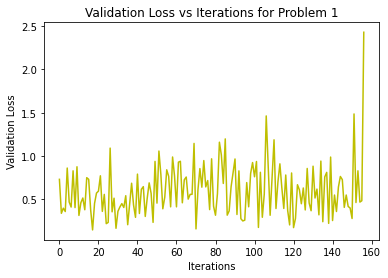

In [150]:
#Plotting validation loss vs number of iterations
x = np.arange(len(val_loss))
plt.plot(x,val_loss,'y')
plt.xlabel("Iterations")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Iterations for Problem 1")

In [82]:
#Problem 2
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [83]:
Transform = thv.transforms.ToTensor() #helps transform downloaded dataset to tensor
train = thv.datasets.MNIST('../dat///////a' , download=True , train=True ,transform=Transform)
test = thv.datasets.MNIST('../dat///////a' , download=True , train=False ,transform=Transform)

In [84]:
#DataLoader helps load datasets (both data and targets) by iterating with given batch size
train_loader = DataLoader(train, batch_size=32,shuffle= True)
valid_loader = DataLoader(train,batch_size=32,shuffle=False) #No shuffling in validation
test_loader = DataLoader(test,batch_size=32,shuffle=False) #No shuffling in testing

In [123]:
#defining network architecture
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    #initializing layer structures, weights and bias
    self.d1 = torch.nn.Linear(784,10)
    self.d1.weight.data.uniform_(0.0, 1.0)
    self.d1.bias.data.fill_(0)
    self.dropout = torch.nn.Dropout(0.25)
    

  def forward(self,X):
    #flow of data
    
    out = self.dropout(X)
    out= self.d1(out)
    out=F.relu(out)
    return F.softmax(out,dim=1)

model = MLP()
print(model)

MLP(
  (d1): Linear(in_features=784, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [124]:
criterion = torch.nn.CrossEntropyLoss() #cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #SGD optimizer
epochs = 100
loss_graph = []

for i in range(epochs):
  epoch_loss = 0.0
  model.train() #preparing model for training
  for data,label in train_loader: #loads training data and training labels simultaneously

    optimizer.zero_grad() #gradients =0
    y_pred = model(data.view(32,-1)) #reshaping batch_sizex28x28 data to batch_sizex784
    loss = criterion(y_pred,label) #loss per iteration
    #print(loss)
 
    loss.backward() #backpropagation
    optimizer.step() #taking one step towards minimum

    epoch_loss += y_pred.shape[0] * loss.item() #loss in epoch

  epoch_loss = epoch_loss / len(train_loader.sampler) #average loss in epoch
  print('Epoch: {} Training Loss: {}'.format(i+1, epoch_loss))
  loss_graph.append(epoch_loss) #saving average epoch loss for graph




Epoch: 1 Training Loss: 1.9153033194859823
Epoch: 2 Training Loss: 1.7404184558868407
Epoch: 3 Training Loss: 1.700381471824646
Epoch: 4 Training Loss: 1.6865916488011679
Epoch: 5 Training Loss: 1.67848734887441
Epoch: 6 Training Loss: 1.6717306491851807
Epoch: 7 Training Loss: 1.667540311050415
Epoch: 8 Training Loss: 1.6645080846150717
Epoch: 9 Training Loss: 1.662058016649882
Epoch: 10 Training Loss: 1.660948903465271
Epoch: 11 Training Loss: 1.6591929280598958
Epoch: 12 Training Loss: 1.6564645523071289
Epoch: 13 Training Loss: 1.6552235390345256
Epoch: 14 Training Loss: 1.6540092551549275
Epoch: 15 Training Loss: 1.6534235527674357
Epoch: 16 Training Loss: 1.6511933385848998
Epoch: 17 Training Loss: 1.650715505917867
Epoch: 18 Training Loss: 1.6497589884440105
Epoch: 19 Training Loss: 1.6495953932444254
Epoch: 20 Training Loss: 1.648813385073344
Epoch: 21 Training Loss: 1.6483884767532349
Epoch: 22 Training Loss: 1.6478747387568156
Epoch: 23 Training Loss: 1.6462320463180542
Epoch

Text(0.5, 1.0, 'Training Loss vs Epoch for Problem 2(a)')

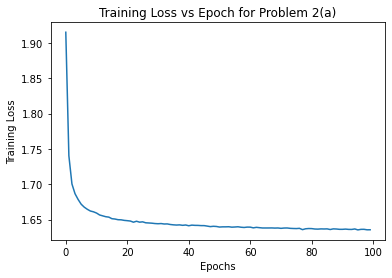

In [125]:
#Training loss per epoch graph
x = range(len(loss_graph))
plt.plot(x,loss_graph)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch for Problem 2(a)")

In [126]:
test_loss = 0.0
model.eval() # preparing model for evaluation
pred,test_loss_graph = [],[]
c=0
for data, target in test_loader:
    # forward pass
    output = model(data.view(-1,784)) #softmax output
    temp = output.detach().numpy() #turning output from tensor to numpy array
    for i in range(len(output)):

      pred.append(np.argmax(temp[i]))
      if np.argmax(temp[i])==target[i]: #finding accuracy
        c+=1
    loss = criterion(output, target) #test loss
  
    test_loss = loss.item() #test loss over minibatch
    test_loss_graph.append(test_loss) #saving it for graph

print("Testing accuracy: ",c/10000)

Testing accuracy:  0.8403


Text(0.5, 1.0, 'Test Loss vs Iteration for problem 2(a)')

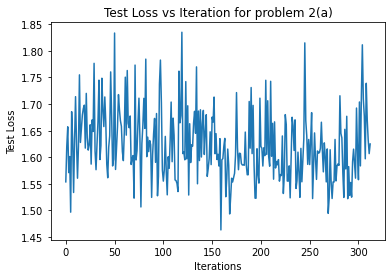

In [127]:
#Plot of test loss vs iteration
plt.plot(np.arange(len(test_loss_graph)),test_loss_graph)
plt.xlabel("Iterations")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Iteration for problem 2(a)")

In [91]:
#defining second neural network architecture
class MLP2(torch.nn.Module):
  def __init__(self):
    super(MLP2,self).__init__()
    #initializing layers,weights and biases
    self.d2 = torch.nn.Linear(784,10)
    self.d2.weight.data.uniform_(0.0, 1.0)
    self.d2.bias.data.fill_(0)
    self.dropout2 = torch.nn.Dropout(0.5)
    

  def forward(self,X):
    #data flow
    out = self.dropout2(X)
    out= self.d2(out)
    out=F.relu(out)
    return F.softmax(out,dim=1)

model2 = MLP2()
print(model2)

MLP2(
  (d2): Linear(in_features=784, out_features=10, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)


In [92]:
##Problem 2 (b)
loss_graph=[]
error_graph =[]
criterion = torch.nn.CrossEntropyLoss() #cross entropy loss
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1) #Adam optimizer with default beta values
epochs = 100


for i in range(epochs):
  epoch_loss = 0.0
  model2.train() #preparing model for training
  for data,label in train_loader:

    c=0.0
    optimizer.zero_grad() #making all gradients 0 
    y_pred = model2(data.view(-1,784)) #flattening data from batch_sizex28x28 to batch_sizex784
    temp = y_pred.detach().numpy() #turning model output from tensor to numpy

    for j in range(len(temp)):

      pred.append(np.argmax(temp[j])) #prediction is index of maximum probabilities
      if np.argmax(temp[j])!=label[j]:
        c+=1/len(temp) #finding errors

    loss = criterion(y_pred,label) #loss calculation
    #print(loss)

    loss.backward() #backpropagation
    optimizer.step() #one step towards minimum

    epoch_loss += y_pred.shape[0] * loss.item() #loss in one epoch
    error_graph.append(c) #error for one epoch saved

  epoch_loss = epoch_loss / len(train_loader.sampler) #average epoch loss
  loss_graph.append(epoch_loss) #saving average epoch loss for plot
  print('Epoch: {} Training Loss: {}'.format(i+1,  epoch_loss))


Epoch: 1 Training Loss: 1.823207801437378
Epoch: 2 Training Loss: 1.7577760043462118
Epoch: 3 Training Loss: 1.7170963211695354
Epoch: 4 Training Loss: 1.7088504512786866
Epoch: 5 Training Loss: 1.704329315185547
Epoch: 6 Training Loss: 1.6977666284561157
Epoch: 7 Training Loss: 1.697337078921
Epoch: 8 Training Loss: 1.6929044356664023
Epoch: 9 Training Loss: 1.6931248271942139
Epoch: 10 Training Loss: 1.6925556071599324
Epoch: 11 Training Loss: 1.6895824997584026
Epoch: 12 Training Loss: 1.688918153889974
Epoch: 13 Training Loss: 1.6868251923878987
Epoch: 14 Training Loss: 1.6884366626739502
Epoch: 15 Training Loss: 1.6887992989857992
Epoch: 16 Training Loss: 1.6899192005793253
Epoch: 17 Training Loss: 1.6882080727259319
Epoch: 18 Training Loss: 1.684986220296224
Epoch: 19 Training Loss: 1.6830484656016031
Epoch: 20 Training Loss: 1.6853021248499553
Epoch: 21 Training Loss: 1.6847475592931112
Epoch: 22 Training Loss: 1.6843230274836223
Epoch: 23 Training Loss: 1.6844622378031413
Epoch

Text(0.5, 1.0, 'Training error vs Iteration in problem 2(b)')

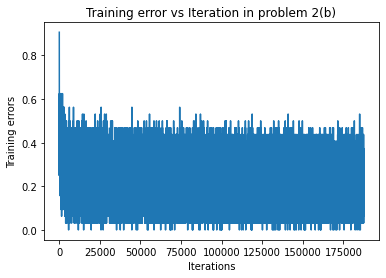

In [93]:
#plot of testing error vs iteration
plt.plot(error_graph)
plt.xlabel("Iterations")
plt.ylabel("Training errors")
plt.title("Training error vs Iteration in problem 2(b)")

Text(0.5, 1.0, 'Training Loss vs Epoch in problem 2(b)')

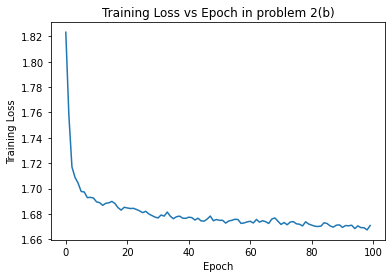

In [94]:
#plot of Training loss vs Epoch
x = np.arange(len(loss_graph))
plt.plot(x,loss_graph)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch in problem 2(b)")

In [118]:
test_loss = 0.0
model.eval() # preparing model for evaluation
err_graph,test_loss_graph2 = [],[]
err=0.0
for data, target in test_loader:
  # forward pass
  output = model2(data.view(-1,784))
  temp = output.detach().numpy()
  err = 0.0
  for i in range(len(output)):

    pred.append(np.argmax(temp[i]))
    if np.argmax(temp[i])!=target[i]:
      err = err+ 1/len(output) #calculating testing errors
  
  loss = criterion(output, target) #test loss

  test_loss = loss.item() #test loss for one minibatch 
  test_loss_graph2.append(test_loss) #average test loss for graph
  err_graph.append(err) #error for every iteration


Text(0.5, 1.0, 'Test Loss vs Iterations for problem 2(b)')

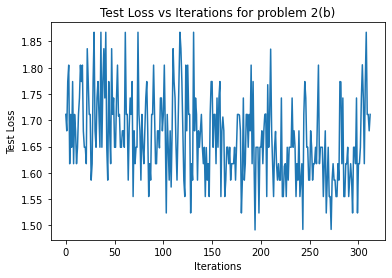

In [120]:
#plot of test loss vs iteration
plt.plot(test_loss_graph2)
plt.xlabel("Iterations")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Iterations for problem 2(b)")

Text(0.5, 1.0, 'Test Errors vs Iterations for problem 2(b)')

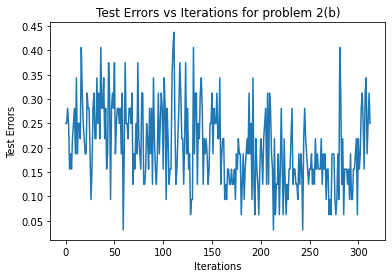

In [112]:
#plot of test error vs iterations
plt.plot(err_graph)
plt.xlabel("Iterations")
plt.ylabel("Test Errors")
plt.title("Test Errors vs Iterations for problem 2(b)")